# Modellierung der Vorhersage der Bauteiltemperatur


Dieses Notebook beschäftigt sich mit der Entwicklung von Vorhersagemodellen für die Zielgröße. Hierzu werden verschiedene Featuresets und Modelle verwendet, um die bestmögliche Vorhersagegenauigkeit zu erreichen.

## Einstellungen und Datenvorbereitung

- **Import relevanter Bibliotheken**
- **Metrik:** Die Leistung der Modelle wird anhand der `neg_mean_absolute_error`-Metriken bewertet.
- **Zielgröße (Target):** `Bauteil_Temp`
- **Irrelevante Spalten:** Diese Spalten werden aus dem Feature-Set entfernt, da sie für die Vorhersage nicht benötigt werden.

In [ ]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))

from sklearn.model_selection import train_test_split, KFold
from IPython.display import display, HTML
from helpers.model_utils import (load_and_prepare_data, 
                                 display_top_models_for_target, 
                                 train_and_tune_models_regression, 
                                 compare_results_regression,  
                                 save_scores_to_csv, 
                                 analyze_model_performance, 
                                 plot_scores_and_percent_diff,
                                 direcetion_results,
                                 compare_smote_effects,
                                 filter_and_retrain_with_vif)
from helpers.model_pipelines import  (define_pipelines_BauteilTemp, 
                                      shap_analysis, 
                                      load_and_split_data,
                                      shap_analysis_single_model)


In [ ]:
# Einstellungen Notebook
target_name = "Bauteiltempartur"

# Metrik auswählen
metric = "neg_mean_absolute_error"  

# Zielgröße
target_column = 'Bauteil_Temp'  
irrelevant_columns = ['Material_con', 'Position_con', 'Ergebnis_con', 'richtig_verbaut', 'Zeit', 'VersuchID','umformzeit','synthetisch','Probenhoehe'
                      ]

# Einfluss der Verkippungssensoren
verkippungsfeatures = ["Verkippung_1", "Verkippung_2", "Verkippung_3", "Verkippung_4", 
                      "Verkippung_1_Min", "Verkippung_1_Max", "Verkippung_1_Mean", "Verkippung_1_Median", "Verkippung_1_Std", 
                      "Verkippung_2_Min","Verkippung_2_Max","Verkippung_2_Mean","Verkippung_2_Median","Verkippung_2_Std","Verkippung_3_Min",
                      "Verkippung_3_Max","Verkippung_3_Mean","Verkippung_3_Median","Verkippung_3_Std","Verkippung_4_Min","Verkippung_4_Max",
                      "Verkippung_4_Mean","Verkippung_4_Median","Verkippung_4_Std", "tilt_x_tiefster", "tilt_y_tiefster", "tilt_x_t0", "tilt_y_t0"]

# Mapping Pfad für Labels
label_mapping_path = "../data_preparation/mappings/label_mappings_binary.json"

# Verkippung berücksichtigen?
Verkippung = True

if not Verkippung:
    irrelevant_columns.extend(verkippungsfeatures)
    
# SHAP Analyse durchführen?
shap_on = False

plot_type = 'summary'  # Alternativ: "summary", "bar" oder "interaction" oder "violin"
plot_type = str(plot_type)


# Plots speichern?
save_plots = True

# mit SMOTE (synthethische Erweiterung der Trainingsdaten)?
smote_on = True

# Bauteil Temp
bauteil_temp = True # Es gibt keine Bauteiltemperatur, True nur für die Verzeichniserstellung

In [ ]:
# Pfade zu den Daten
test_filepath = f"../datasets/test_{target_column}.pkl"
if smote_on:
    # Pfade zu den SMOTE Trainingsdaten
    train_filepath = f"../datasets/train_{target_column}_erweitert.pkl"
    test_filepath = f"../datasets/test_{target_column}_clean.pkl"
else: 
    save_plots = False
    train_filepath = f"../datasets/train_{target_column}_clean.pkl"
    test_filepath = f"../datasets/test_{target_column}_clean.pkl"

# Lade und bereite Trainings- und Testdaten vor
X_train_original, y_train = load_and_prepare_data(train_filepath, target_column, irrelevant_columns)
X_test_original, y_test = load_and_prepare_data(test_filepath, target_column, irrelevant_columns)
    
# Überprüfen der Shapes
print(f"Trainingsdaten: X_train={X_train_original.shape}, y_train={y_train.shape}")
print(f"Testdaten: X_test={X_test_original.shape}, y_test={y_test.shape}")

# Zentrale Pipeline und Parameter
input_dim = X_train_original.shape[1]
target_pipeline = define_pipelines_BauteilTemp()
pipelines, param_grids = target_pipeline

# Cross-Validation Setup
# KFold für Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)


Trainingsdaten: X_train=(5612, 69), y_train=(5612,)
Testdaten: X_test=(123, 69), y_test=(123,)


In [4]:
y_train = y_train.round(2)
y_test = y_test.round(2)

In [5]:
y_train

0       1144.01
1       1079.46
2       1163.72
3       1210.78
4       1182.48
         ...   
5607    1201.90
5608    1194.23
5609    1221.78
5610    1206.13
5611    1199.07
Name: Bauteil_Temp, Length: 5612, dtype: float64

# Process Features Dataset

In diesem Abschnitt wird das Datenset für die Prozessmerkmale vorbereitet und trainiert. Das Dataset wird angepasst, indem irrelevante Spalten entfernt und die relevanten Features extrahiert werden. Anschließend werden verschiedene Machine-Learning-Modelle trainiert, die darauf abzielen, die Zielgröße basierend auf den Prozessmerkmalen vorherzusagen.

In [6]:
# Einstellungen Dataset
dataset_name = "process_features"
target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp)


# Auswahl der Process Features aus dem Dataset
columns_process_features = [
    "VersuchID",
    "Berührzeit",
    "Höhe_Wegmessung_Aufprall",
    "Umformzeit",
    "Tiefster_Punkt",
    "Energie_Aufprall",
    "Motorstrom_Durchschnitt",
    "Energie_ab_Durchschnitt",
    #"Bauteil_Temp",
    "Werkzeug_Temp",
    "Material_con",
    "Position_con",
    "Ergebnis_con",
    "Probenhoehe",
]

# Sicherstellen, dass nur existierende Spalten verwendet werden
columns_to_keep_train = [col for col in columns_process_features if col in X_train_original.columns]

# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original[columns_to_keep_train]
X_test = X_test_original[columns_to_keep_train]

In [7]:
X_train

,Berührzeit,Höhe_Wegmessung_Aufprall,Umformzeit,Tiefster_Punkt,Energie_Aufprall,Motorstrom_Durchschnitt,Energie_ab_Durchschnitt,Werkzeug_Temp
0,265.000000,65.068001,234.000000,29.134115,0.012410,3.312901,176.000000,52.260000
1,320.000000,67.455147,270.000000,29.531973,0.012531,3.314861,195.000000,53.280000
2,250.000000,66.840279,236.000000,28.808594,0.009326,3.224455,178.000000,46.890000
3,262.000000,67.129623,244.000000,28.790510,0.012010,3.329049,175.000000,45.740000
4,286.500000,68.684898,266.500000,29.043692,0.012169,3.343708,183.000000,49.140000
...,...,...,...,...,...,...,...,...
5607,334.900580,67.665726,311.729298,36.933038,0.005145,3.199011,95.715475,68.028557
5608,354.967025,68.539918,256.523056,28.431636,0.009600,3.288711,170.580002,61.684301
5609,357.380619,67.224012,320.654240,33.390720,0.004986,3.261672,119.733951,48.141811
5610,350.227493,68.465933,321.694518,34.643993,0.005154,3.215960,132.333576,52.103239


## Training

In diesem Abschnitt wird das Training der Modelle durchgeführt. Die Modelle werden mit Hilfe von Cross-Validation optimiert, um eine robuste Bewertung der Modellleistung sicherzustellen. Hyperparameter-Tuning wird genutzt, um die besten Einstellungen für jedes Modell zu finden und die Generalisierungsfähigkeit auf Testdaten zu verbessern.

In [8]:
# Modelltraining und Bewertung
input_dim = X_train.shape[1]
pipelines ,param_grids= define_pipelines_BauteilTemp(input_dim)
best_pipelines, results = train_and_tune_models_regression(
    pipelines, 
    param_grids, 
    X_train, 
    y_train, 
    kf, 
    X_test=X_test, 
    y_test=y_test
)
# Ergebnisse in DataFrame speichern
results_df_1 = pd.DataFrame.from_dict(results, orient='index').T
#results_df.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse in tabellarischer Form anzeigen
display(HTML(results_df_1.to_html()))
#results_df_1.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse speichern
save_scores_to_csv(
    results=results_df_1,  # Direkt das DataFrame übergeben
    output_dir=target_dir,    # Zielverzeichnis
    file_name=f"model_scores_{dataset_name}{balance_suffix}.csv",  # Dateiname
    Verkippung=Verkippung    # Flag für Verkippung
)

Training XGBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Berechnung der finalen Scores für XGBoost...
Training AdaBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Berechnung der finalen Scores für AdaBoost...
Training SVR...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Berechnung der finalen Scores für SVR...
Training Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Berechnung der finalen Scores für Random Forest...
Training Lineare Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Berechnung der finalen Scores für Lineare Regression...


,XGBoost,AdaBoost,SVR,Random Forest,Lineare Regression
Test MSE,4186.860505,1457.196909,7775.623501,4845.576513,8514.115939
Test MAE,46.391949,30.233421,70.391468,48.367421,73.726366
Test R²,0.850896,0.948106,0.723092,0.827438,0.696792
Test RMSE,64.705954,38.173249,88.179496,69.610175,92.271967
percent_diff_MSE,23.579149,23.394388,18.325313,6.882979,1.335121
percent_diff_MAE,11.206267,19.5884,7.172883,7.675132,2.576358
percent_diff_R²,0.56733,0.16627,0.805687,2.621811,7.315627
percent_diff_RMSE,11.830829,11.737481,9.181969,3.442509,0.667568
best_params,"{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.4, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 3, 'clf__n_estimators': 450, 'clf__subsample': 0.8}","{'clf__estimator': DecisionTreeRegressor(max_depth=4), 'clf__learning_rate': 0.5, 'clf__n_estimators': 144}","{'clf__C': 0.5, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}","{'clf__bootstrap': True, 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 3, 'clf__n_estimators': 200}",{}


Scores erfolgreich gespeichert unter: results/Bauteiltempartur//process_features/model_scores_process_features.csv


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(y_true, y_pred, model_name="Modell"):
    """
    Erstellt einen Scatter-Plot für tatsächliche vs. vorhergesagte Werte.
    
    Args:
        y_true (array-like): Tatsächliche Werte.
        y_pred (array-like): Vorhergesagte Werte.
        model_name (str): Name des Modells für den Titel.
    """
    plt.figure(figsize=(8, 6))
    
    # Streudiagramm
    plt.scatter(y_pred, y_true, color='red', alpha=0.6, label="Datenpunkte")
    
    # Diagonale Linie (perfekte Vorhersage)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Perfekte Vorhersage")
    
    # Achsenbeschriftung
    plt.xlabel("Vorhergesagte Bauteiltemperatur (° C)")
    plt.ylabel("Tatsächliche Bauteiltemperatur (° C)")
    plt.title(f"Tatsächliche vs. vorhergesagte Bauteiltemperatur ({model_name})")
    #plt.legend()
    plt.grid(True)
    
    plt.show()

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


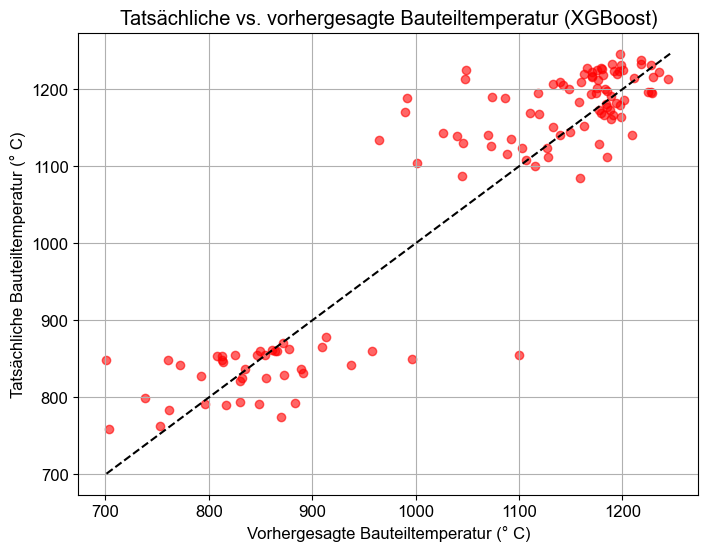

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(


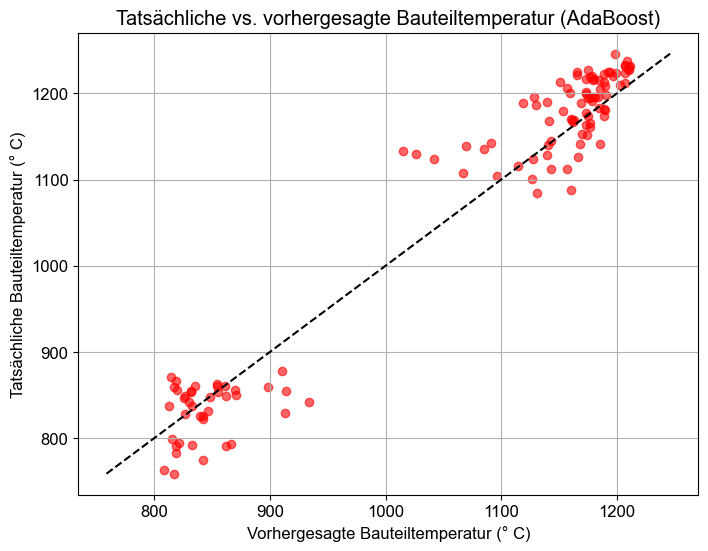

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


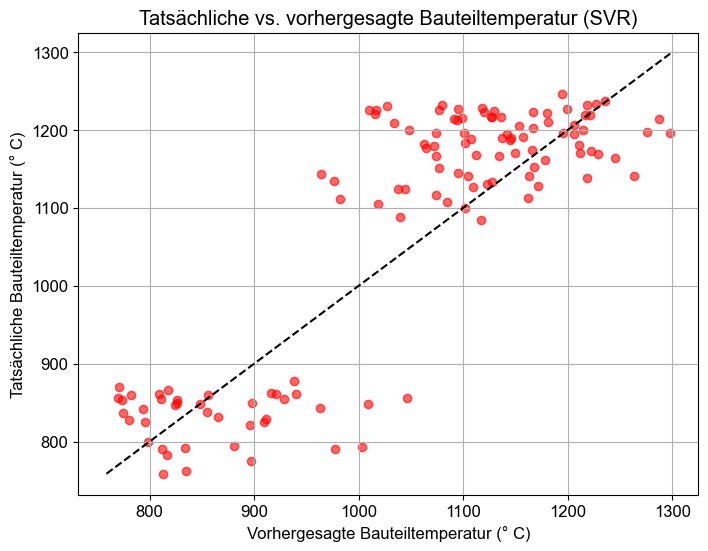

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


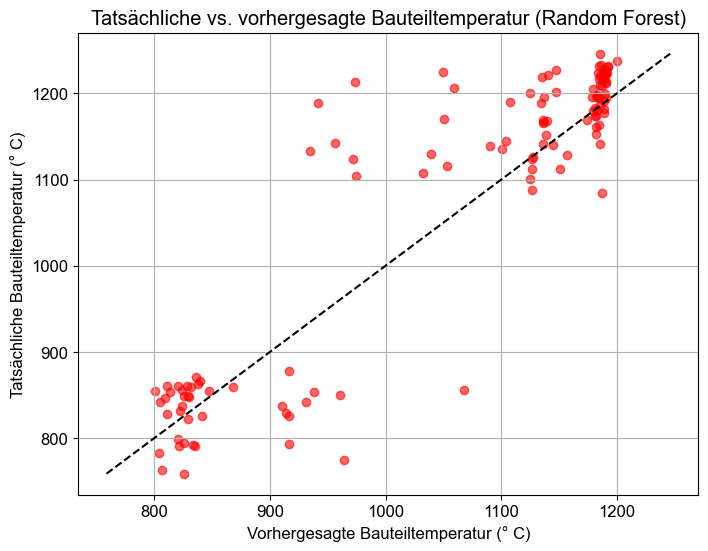

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


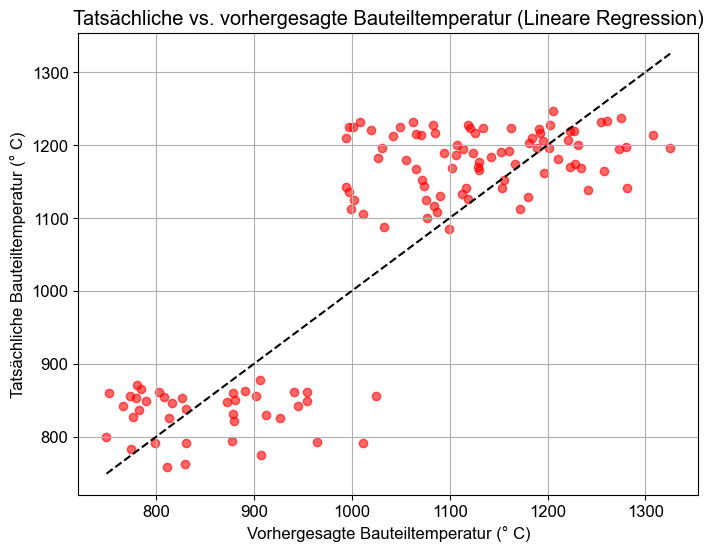

Fehler: Modell 'Lineare Regression' wurde nicht gefunden.


In [10]:
# Schritt 2: Vorhersagen für ein Modell generieren (z. B. XGBoost)

for model_name in best_pipelines:
    model = best_pipelines[model_name]
    y_pred = model.predict(X_test)

    # Schritt 3: Visualisierung
    plot_actual_vs_predicted(y_test, y_pred, model_name=model_name)
else:
    print(f"Fehler: Modell '{model_name}' wurde nicht gefunden.")

## Overfitting Test

In diesem Abschnitt wird die Überprüfung von Overfitting durch die Analyse von Learning Curves und Validation Curves durchgeführt, um den Bias-Variance-Tradeoff besser zu verstehen. Die `analyze_model_performance` Funktion aus der `model_pipelines.py` führt diese Analysen durch und erstellt entsprechende Plots. Es werden sowohl die Trainingsscores als auch die Testscores über verschiedene Größen des Trainingssets und Hyperparameterbereiche betrachtet, um die Modellstabilität und die Generalisierungsfähigkeit zu bewerten. Dies hilft dabei, die optimale Komplexität der Modelle zu bestimmen und sicherzustellen, dass sie gut auf unbekannte Daten generalisieren.


Learning Curve Analyse für Bauteiltempartur:
Analysiere Modell: XGBoost...
Erstelle Validation Curve für XGBoost...
Validation Curve gespeichert unter: results/Bauteiltempartur//process_features/XGBoost/validation_curve_XGBoost_clf__n_estimators.svg


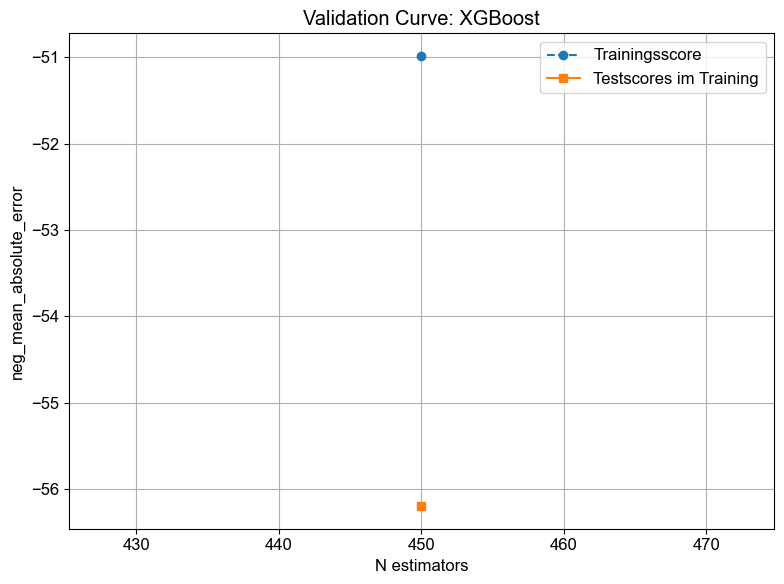

Erstelle Learning Curve für XGBoost...
Learning Curve gespeichert unter: results/Bauteiltempartur//process_features/XGBoost/learning_curve_XGBoost.svg


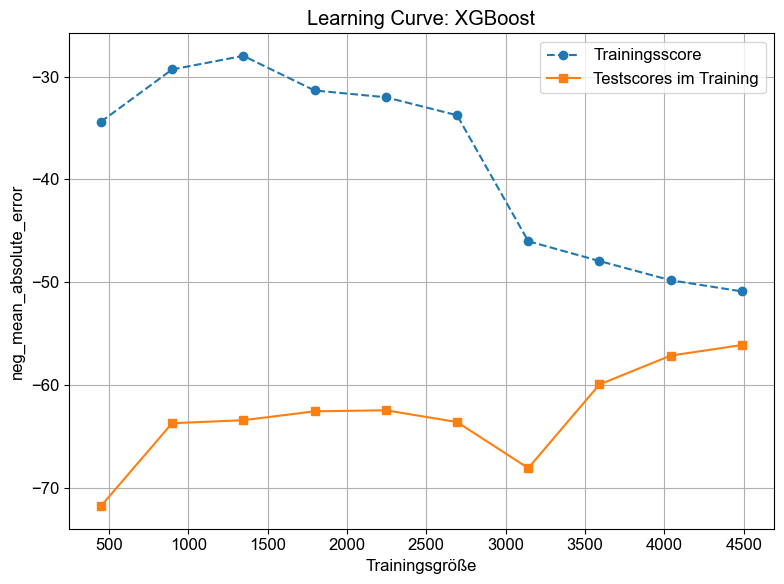

Analysiere Modell: AdaBoost...
Erstelle Validation Curve für AdaBoost...
Validation Curve gespeichert unter: results/Bauteiltempartur//process_features/AdaBoost/validation_curve_AdaBoost_clf__n_estimators.svg


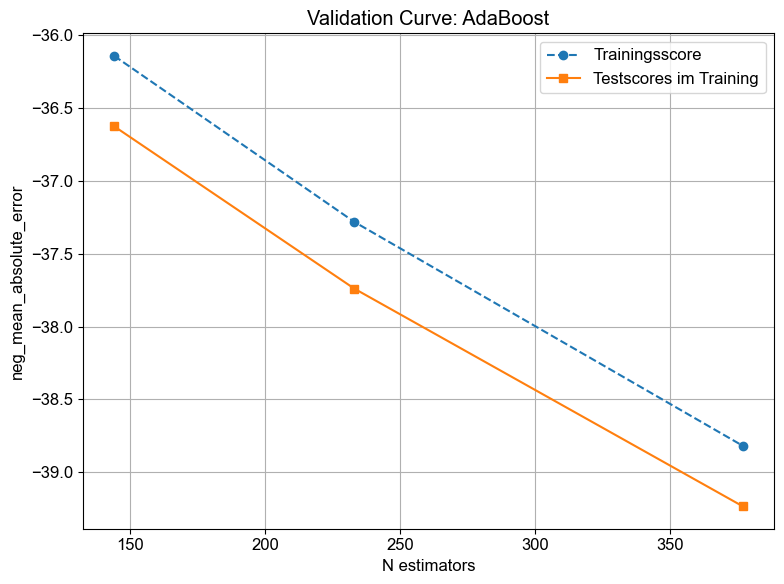

Erstelle Learning Curve für AdaBoost...
Learning Curve gespeichert unter: results/Bauteiltempartur//process_features/AdaBoost/learning_curve_AdaBoost.svg


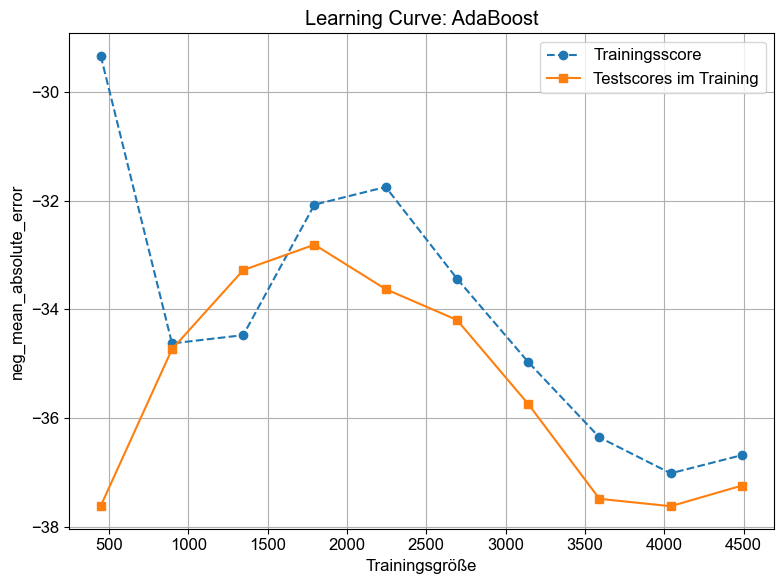

Analysiere Modell: SVR...
Erstelle Validation Curve für SVR...
Validation Curve gespeichert unter: results/Bauteiltempartur//process_features/SVR/validation_curve_SVR_clf__C.svg


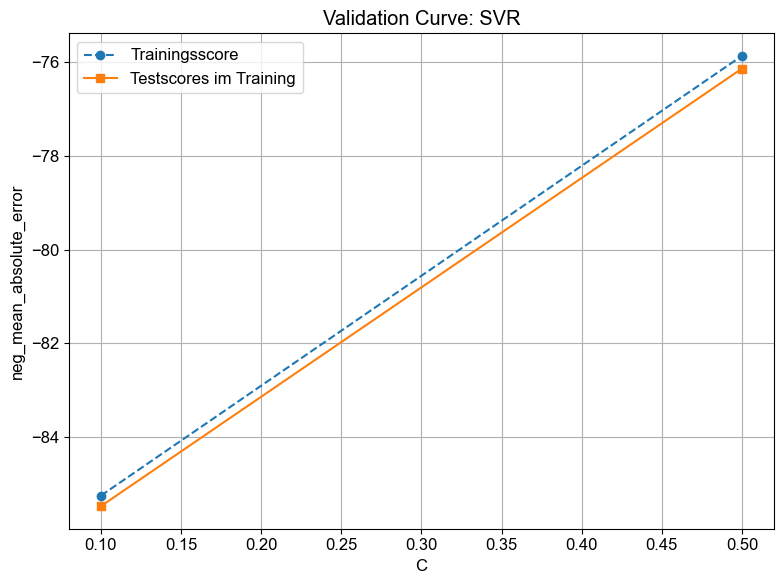

Erstelle Learning Curve für SVR...
Learning Curve gespeichert unter: results/Bauteiltempartur//process_features/SVR/learning_curve_SVR.svg


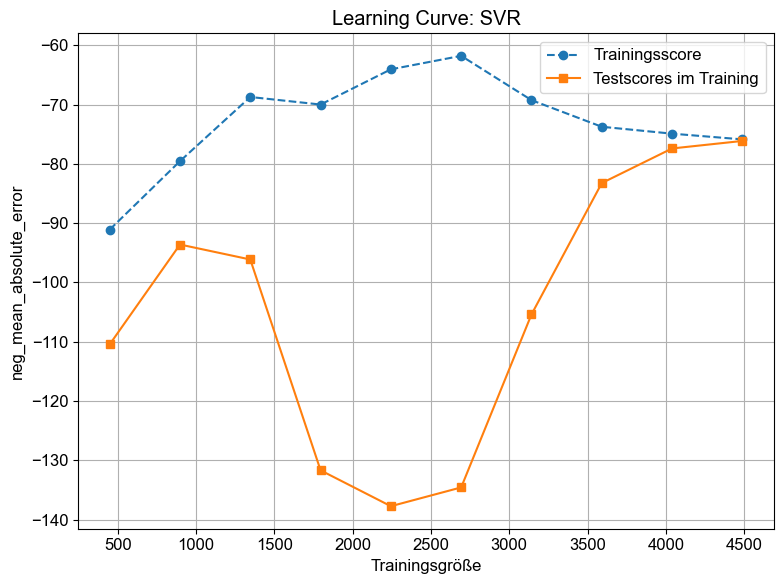

Analysiere Modell: Random Forest...
Erstelle Validation Curve für Random Forest...
Validation Curve gespeichert unter: results/Bauteiltempartur//process_features/Random Forest/validation_curve_Random Forest_clf__n_estimators.svg


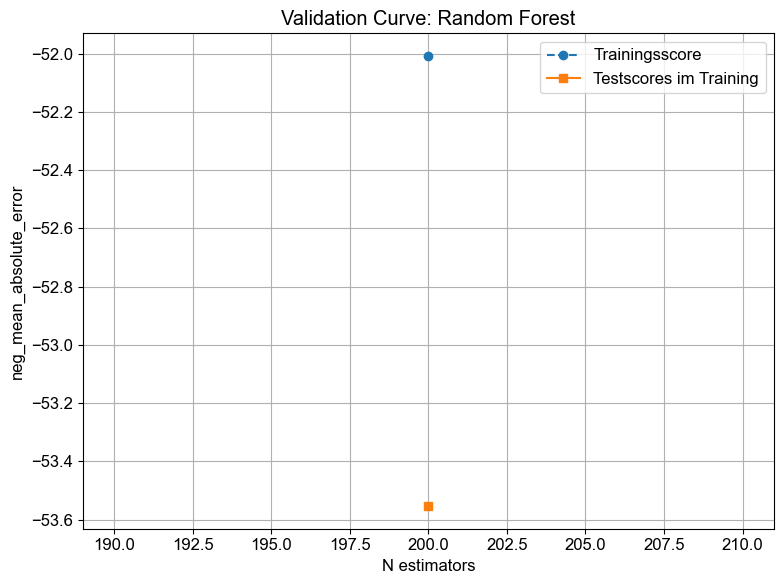

Erstelle Learning Curve für Random Forest...
Learning Curve gespeichert unter: results/Bauteiltempartur//process_features/Random Forest/learning_curve_Random Forest.svg


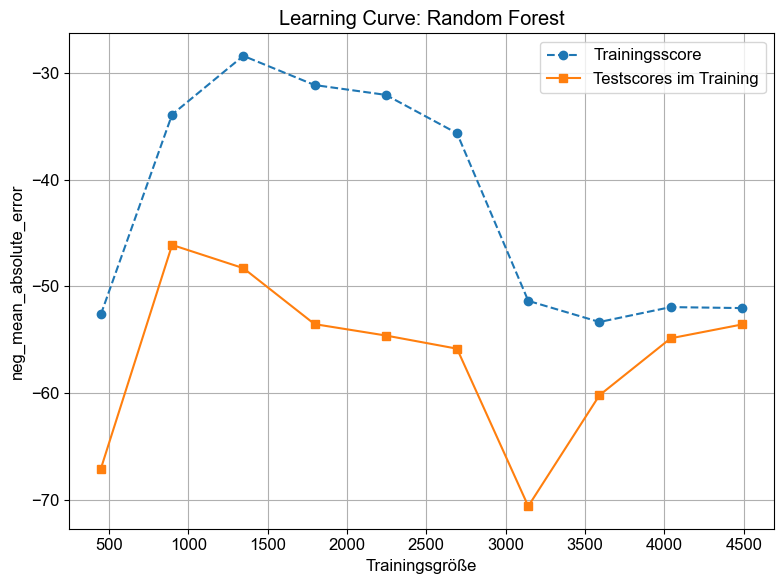

Analysiere Modell: Lineare Regression...
Keine Hyperparameter für Lineare Regression gefunden.


In [11]:
# Overfitting überprüfen 
# Analyse von Learning Curves für Bias-Variance-Tradeoff
print(f"\nLearning Curve Analyse für {target_name}:")

# Analyse der Modellleistung
analyze_model_performance(
    pipelines=pipelines, 
    param_grids=param_grids, 
    X=X_train, 
    y=y_train, 
    scoring=metric, 
    cv=kf,
    save_plots=save_plots,
    output_dir= target_dir,
    Verkippung=Verkippung
)


In [12]:
# Alternative Validierungsverfahren
#print("\nAlternative Validierungsverfahren:")
#for name, pipeline in best_pipelines.items():
#    print(f"Alternative Validierungsverfahren für {name}...")
#    test_alternative_validation(pipeline, X_train, y_train)

## SHAP-Analyse

In diesem Abschnitt führen wir eine SHAP-Analyse durch, um die Einflüsse der einzelnen Features auf die Vorhersagen der besten Modelle zu verstehen. Die Ergebnisse dieser Analyse helfen uns, die Modellentscheidungen transparenter zu machen. Anschließend laden wir Diagramme, die die besten drei Modelle basierend auf unterschiedlichen Metriken darstellen. Diese Visualisierungen unterstützen die Bewertung der Modellperformance und die Identifizierung von Schlüsselfeatures, die die Zielgröße beeinflussen.

In [13]:
# SHAP-Analyse
if shap_on:
    shap_analysis(
        best_pipelines=best_pipelines,
        X_train=X_train,
        target_name=target_name,
        dataset_name=dataset_name,
        output_dir=target_dir,
        plot_type=plot_type,  # Alternativ: "bar" oder "interaction" oder "violin"
        save_plots=save_plots,
        verkippung=Verkippung
    ) 

In [14]:
# Diagramme aus der Zielgröße laden
display_top_models_for_target(
    target_dir,
    results_df_1,
    metric= 'Test MSE',
    top_n=3,  # Nur die besten 3 Modelle anzeigen
)


Top-3 Modelle basierend auf der Metrik 'Test MSE':
Lineare Regression    8514.115939
SVR                   7775.623501
Random Forest         4845.576513
Name: Test MSE, dtype: object

Anzeigen der SHAP-Diagramme für Modelle in den Top-3 (zusammengefasst): SVR, Random Forest, Lineare Regression
SHAP-Diagramm für SVR nicht gefunden unter results/Bauteiltempartur//process_features/SVR/shap_summary_SVR.svg.
SHAP-Diagramm für Random Forest nicht gefunden unter results/Bauteiltempartur//process_features/Random Forest/shap_summary_Random Forest.svg.
SHAP-Diagramm für Lineare Regression nicht gefunden unter results/Bauteiltempartur//process_features/Lineare Regression/shap_summary_Lineare Regression.svg.


# Aggregierte Daten

In [15]:
# Einstellungen
dataset_name = "aggregated_features"
target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp)



# Auswahl der Process Features aus dem Dataset
columns_aggregated_features = [
    "VersuchID",
    "Berührzeit",
    "Höhe_Wegmessung_Aufprall",
    "Umformzeit",
    "Tiefster_Punkt",
    "Energie_Aufprall",
    "Motorstrom_Durchschnitt",
    "Energie_ab_Durchschnitt",
    #"Bauteil_Temp",
    "Werkzeug_Temp",
    "Material_con",
    "Position_con",
    "Ergebnis_con",
    "Probenhoehe",
    "richtig_verbaut",
    "Wegmessung_Min",
    "Wegmessung_Max",
    "Wegmessung_Mean",
    "Wegmessung_Median",
    "Wegmessung_Std",
    "Verkippung_1_Min",
    "Verkippung_1_Max",
    "Verkippung_1_Mean",
    "Verkippung_1_Median",
    "Verkippung_1_Std",
    "Verkippung_2_Min",
    "Verkippung_2_Max",
    "Verkippung_2_Mean",
    "Verkippung_2_Median",
    "Verkippung_2_Std",
    "Verkippung_3_Min",
    "Verkippung_3_Max",
    "Verkippung_3_Mean",
    "Verkippung_3_Median",
    "Verkippung_3_Std",
    "Verkippung_4_Min",
    "Verkippung_4_Max",
    "Verkippung_4_Mean",
    "Verkippung_4_Median",
    "Verkippung_4_Std",
    "Stoesselhub_Min",
    "Stoesselhub_Max",
    "Stoesselhub_Mean",
    "Stoesselhub_Median",
    "Stoesselhub_Std",
    "Geschwindigkeit_Ges_Min",
    "Geschwindigkeit_Ges_Max",
    "Geschwindigkeit_Ges_Mean",
    "Geschwindigkeit_Ges_Median",
    "Geschwindigkeit_Ges_Std",
    "Presskraft_dyn_Min",
    "Presskraft_dyn_Max",
    "Presskraft_dyn_Mean",
    "Presskraft_dyn_Median",
    "Presskraft_dyn_Std",
    "Motorstrom_Min",
    "Motorstrom_Max",
    "Motorstrom_Mean",
    "Motorstrom_Median",
    "Motorstrom_Std",
]

# Sicherstellen, dass nur existierende Spalten verwendet werden
columns_to_keep_train = [col for col in columns_aggregated_features if col in X_train_original.columns]

# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original[columns_to_keep_train]
X_test = X_test_original[columns_to_keep_train]

## Training

In [16]:
# Modelltraining und Bewertung
input_dim = X_train.shape[1]
pipelines ,param_grids= define_pipelines_BauteilTemp(input_dim)
best_pipelines, results = train_and_tune_models_regression(
    pipelines, 
    param_grids, 
    X_train, 
    y_train, 
    kf, 
    X_test=X_test, 
    y_test=y_test
)

# Ergebnisse in DataFrame speichern
results_df_2 = pd.DataFrame.from_dict(results, orient='index').T
#results_df.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse in tabellarischer Form anzeigen
display(HTML(results_df_2.to_html()))

save_scores_to_csv(
    results=results_df_2,  # DataFrame mit den Scores
    output_dir=target_dir,
    file_name=f"model_scores_{dataset_name}{balance_suffix}.csv",  # Gemeinsamer Basisname
    Verkippung=Verkippung  # Fügt den '_no_tilt'-Suffix hinzu, falls nötig
)

Training XGBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Berechnung der finalen Scores für XGBoost...
Training AdaBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Berechnung der finalen Scores für AdaBoost...
Training SVR...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Berechnung der finalen Scores für SVR...
Training Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Berechnung der finalen Scores für Random Forest...
Training Lineare Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Berechnung der finalen Scores für Lineare Regression...


,XGBoost,AdaBoost,SVR,Random Forest,Lineare Regression
Test MSE,2390.932703,851.852985,4319.39738,1527.735639,2793.572701
Test MAE,36.491843,25.044994,47.79778,29.10665,41.440002
Test R²,0.914853,0.969664,0.846176,0.945594,0.900514
Test RMSE,48.897165,29.186521,65.722122,39.086259,52.854259
percent_diff_MSE,17.825487,7.905771,0.719061,1.896509,9.653211
percent_diff_MAE,10.652998,5.429662,0.141189,1.011237,3.883255
percent_diff_R²,2.923426,0.369745,3.417899,0.972528,1.129631
percent_diff_RMSE,8.930514,3.954431,0.359531,0.948276,4.82942
best_params,"{'clf__colsample_bytree': 0.5, 'clf__gamma': 0.4, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 3, 'clf__n_estimators': 450, 'clf__subsample': 0.8}","{'clf__estimator': DecisionTreeRegressor(max_depth=4), 'clf__learning_rate': 0.1, 'clf__n_estimators': 144}","{'clf__C': 0.5, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}","{'clf__bootstrap': True, 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 3, 'clf__n_estimators': 200}",{}


Scores erfolgreich gespeichert unter: results/Bauteiltempartur//aggregated_features/model_scores_aggregated_features.csv


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


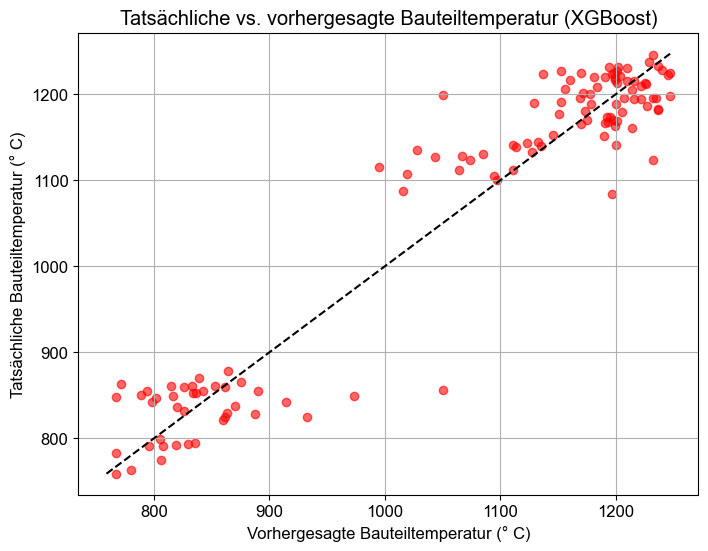

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(


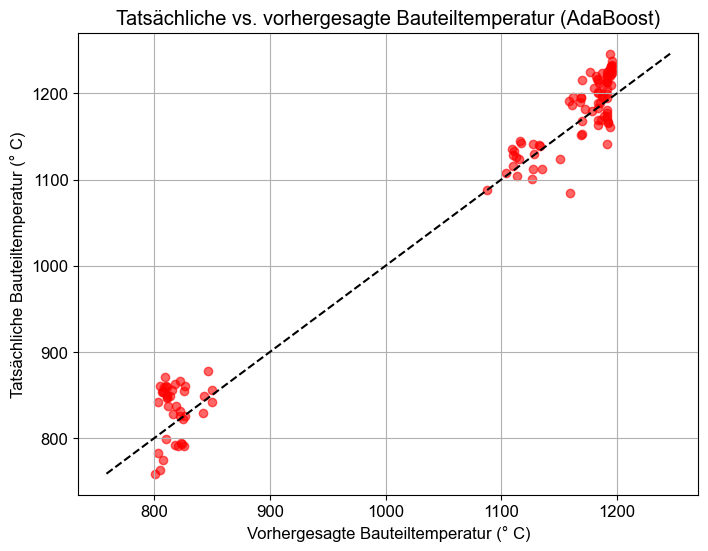

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


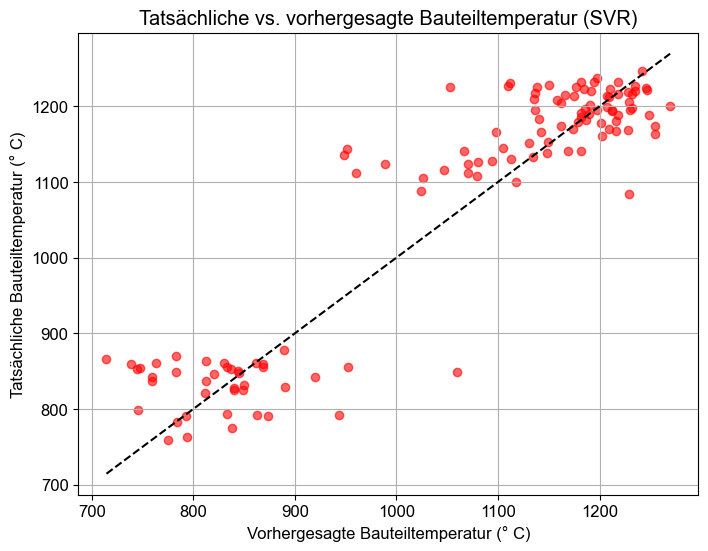

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


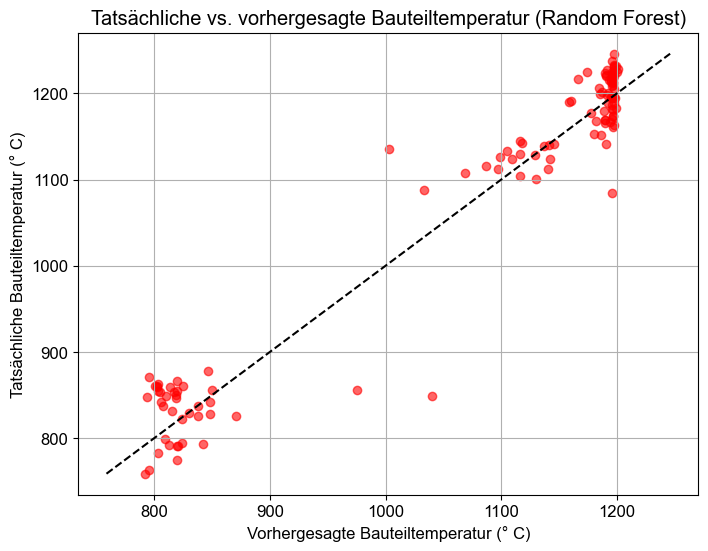

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


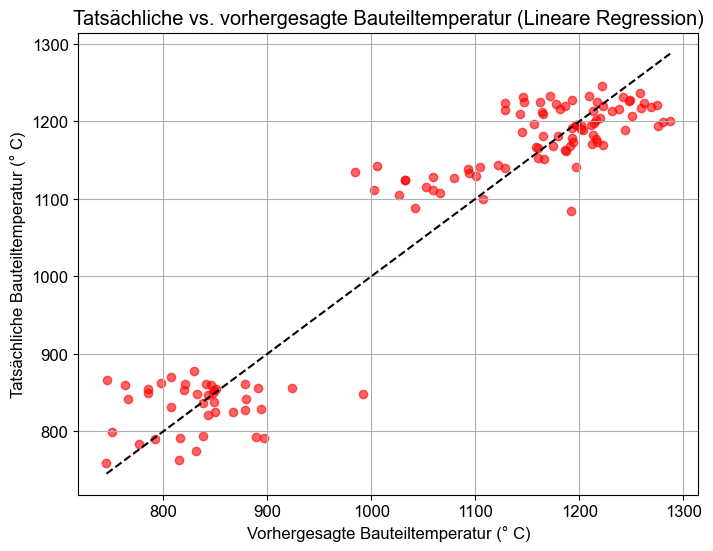

Fehler: Modell 'Lineare Regression' wurde nicht gefunden.


In [17]:
# Schritt 2: Vorhersagen für ein Modell generieren (z. B. XGBoost)
for model_name in best_pipelines:
    model = best_pipelines[model_name]
    y_pred = model.predict(X_test)

    # Schritt 3: Visualisierung
    plot_actual_vs_predicted(y_test, y_pred, model_name=model_name)
else:
    print(f"Fehler: Modell '{model_name}' wurde nicht gefunden.")

## Overfitting Test


Learning Curve Analyse für Bauteiltempartur:
Analysiere Modell: XGBoost...
Erstelle Validation Curve für XGBoost...
Validation Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/XGBoost/validation_curve_XGBoost_clf__n_estimators.svg


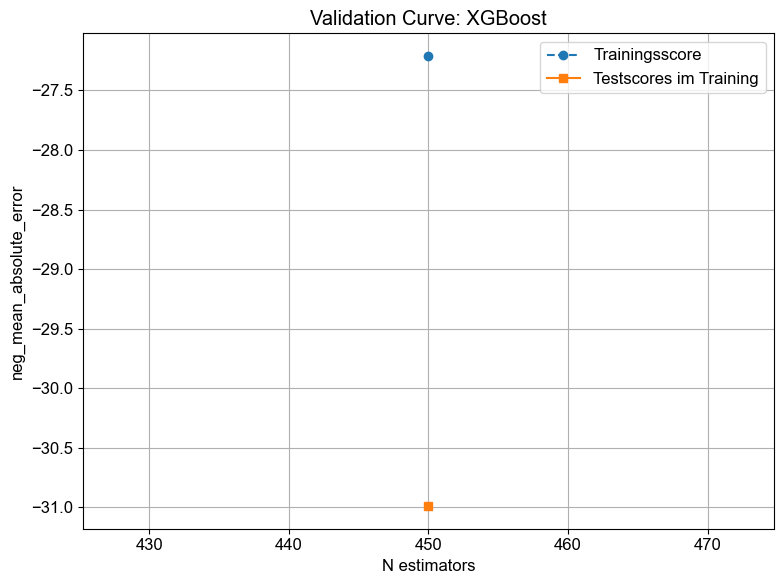

Erstelle Learning Curve für XGBoost...
Learning Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/XGBoost/learning_curve_XGBoost.svg


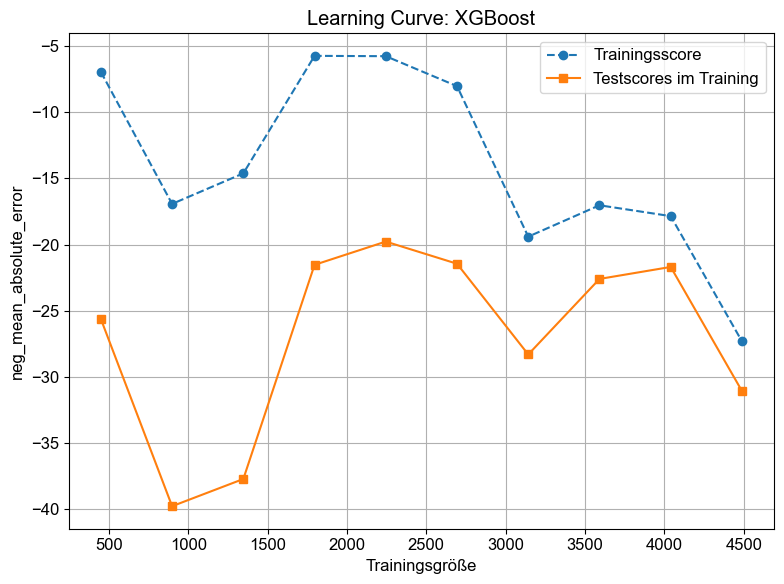

Analysiere Modell: AdaBoost...
Erstelle Validation Curve für AdaBoost...
Validation Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/AdaBoost/validation_curve_AdaBoost_clf__n_estimators.svg


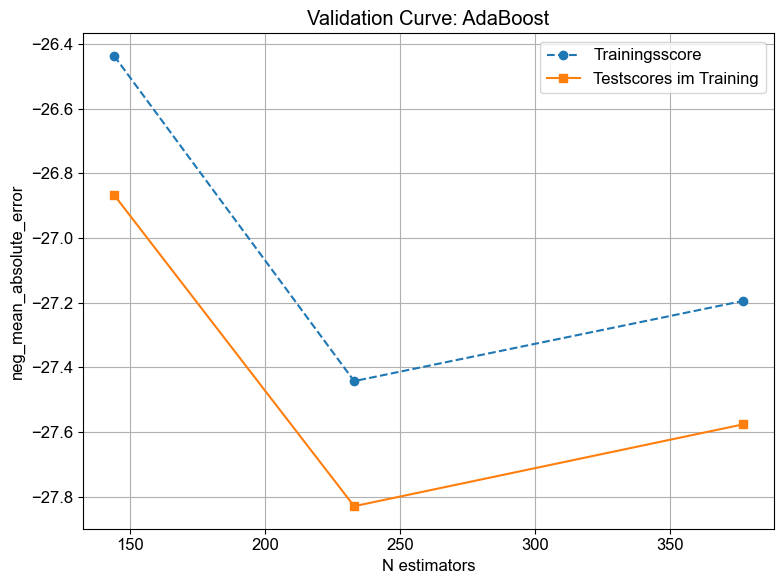

Erstelle Learning Curve für AdaBoost...
Learning Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/AdaBoost/learning_curve_AdaBoost.svg


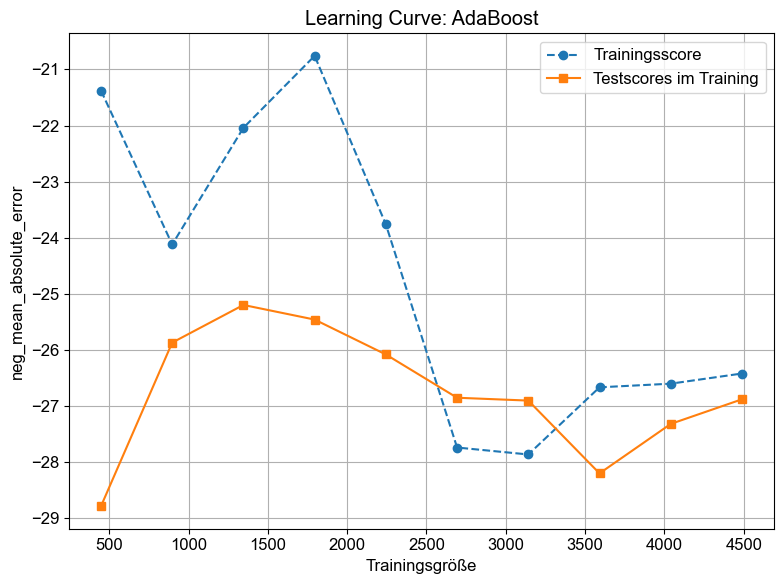

Analysiere Modell: SVR...
Erstelle Validation Curve für SVR...
Validation Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/SVR/validation_curve_SVR_clf__C.svg


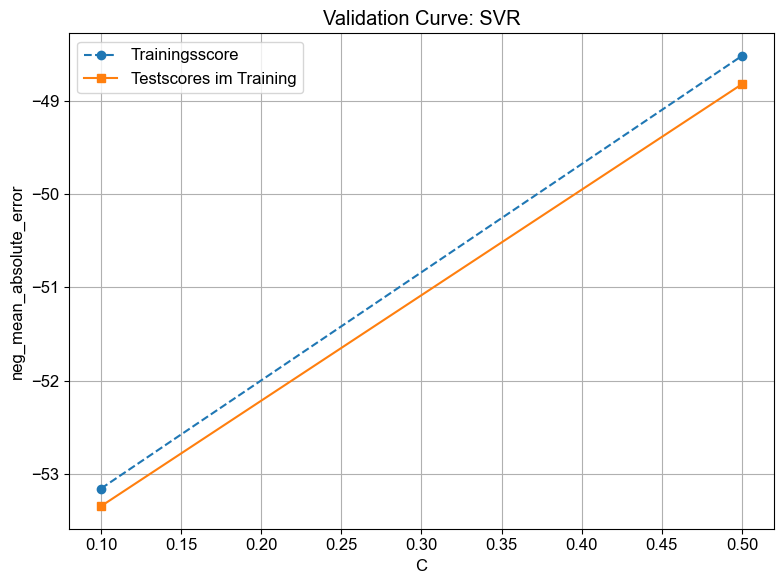

Erstelle Learning Curve für SVR...
Learning Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/SVR/learning_curve_SVR.svg


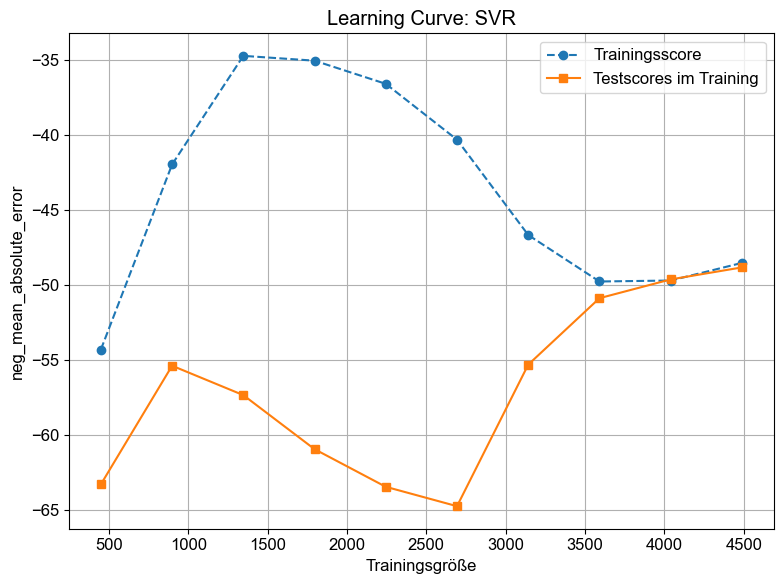

Analysiere Modell: Random Forest...
Erstelle Validation Curve für Random Forest...
Validation Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/Random Forest/validation_curve_Random Forest_clf__n_estimators.svg


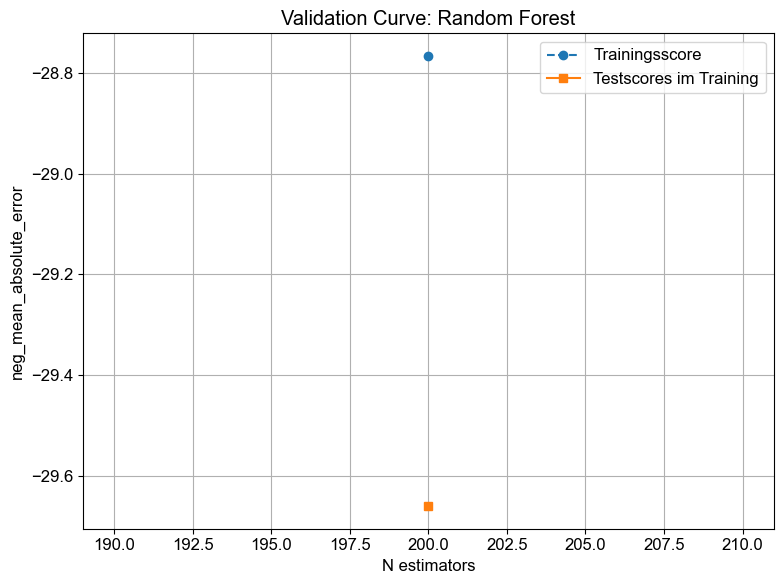

Erstelle Learning Curve für Random Forest...
Learning Curve gespeichert unter: results/Bauteiltempartur//aggregated_features/Random Forest/learning_curve_Random Forest.svg


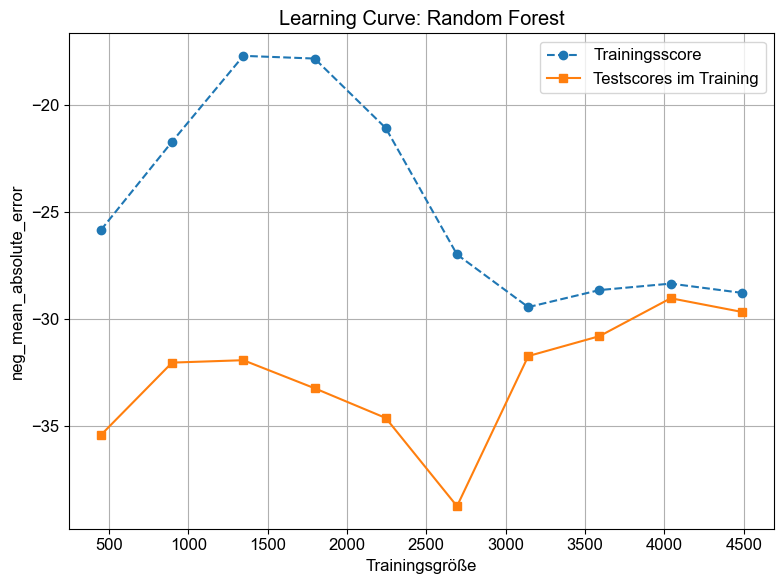

Analysiere Modell: Lineare Regression...
Keine Hyperparameter für Lineare Regression gefunden.


In [18]:
# Overfitting überprüfen 
# Analyse von Learning Curves für Bias-Variance-Tradeoff
print(f"\nLearning Curve Analyse für {target_name}:")

# Analyse der Modellleistung
analyze_model_performance(
    pipelines=pipelines, 
    param_grids=param_grids, 
    X=X_train, 
    y=y_train, 
    scoring=metric, 
    cv=kf,
    save_plots=save_plots,
    output_dir= target_dir,
    Verkippung=Verkippung
)


## SHAP-Analyse

In [19]:
# SHAP-Analyse
if shap_on:
    shap_analysis(
        best_pipelines=best_pipelines,
        X_train=X_train,
        target_name=target_name,
        dataset_name=dataset_name,
        output_dir=target_dir,
        plot_type=plot_type,  # Alternativ: "bar" oder "interaction" oder "violin"
        save_plots=save_plots,
        verkippung=Verkippung
    ) 

In [20]:
# Alle Diagramme aus der Zielgröße "Prozessqualität" laden
display_top_models_for_target(
    target_dir,
    results_df_2,
    metric = 'Test MSE',
    top_n=3  # Nur die besten 3 Modelle anzeigen
)


Top-3 Modelle basierend auf der Metrik 'Test MSE':
SVR                    4319.39738
Lineare Regression    2793.572701
XGBoost               2390.932703
Name: Test MSE, dtype: object

Anzeigen der SHAP-Diagramme für Modelle in den Top-3 (zusammengefasst): SVR, XGBoost, Lineare Regression
SHAP-Diagramm für SVR nicht gefunden unter results/Bauteiltempartur//aggregated_features/SVR/shap_summary_SVR.svg.
SHAP-Diagramm für XGBoost nicht gefunden unter results/Bauteiltempartur//aggregated_features/XGBoost/shap_summary_XGBoost.svg.
SHAP-Diagramm für Lineare Regression nicht gefunden unter results/Bauteiltempartur//aggregated_features/Lineare Regression/shap_summary_Lineare Regression.svg.


# New Features Dataset

In [21]:
# Einstellungen
dataset_name = "new_features"
target_dir, feature_importance_path, balance_suffix, feature_importance_path_best, target_dir_best, tilt_suffix, temp_suffix = direcetion_results(dataset_name, target_name, smote_on, Verkippung, bauteil_temp)

# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original
X_test = X_test_original

In [22]:
# X_train und X_test auf relevante Spalten beschränken
X_train = X_train_original.drop(columns='synthetisch', errors='ignore')


## Training

In [23]:
# Modelltraining und Bewertung
input_dim = X_train.shape[1]
pipelines ,param_grids= define_pipelines_BauteilTemp(input_dim)
best_pipelines, results = train_and_tune_models_regression(
    pipelines, 
    param_grids, 
    X_train, 
    y_train, 
    kf, 
    X_test=X_test, 
    y_test=y_test
)

# Ergebnisse in DataFrame speichern
results_df_3 = pd.DataFrame.from_dict(results, orient='index').T
#results_df.drop(['best_params'], axis=0, inplace=True)

# Ergebnisse in tabellarischer Form anzeigen
display(HTML(results_df_3.to_html()))

save_scores_to_csv(
    results=results_df_3,  # DataFrame mit den Scores
    output_dir=target_dir,
    file_name=f"model_scores_{dataset_name}{balance_suffix}.csv",  # Gemeinsamer Basisname
    Verkippung=Verkippung  # Fügt den '_no_tilt'-Suffix hinzu, falls nötig
)

Training XGBoost...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Berechnung der finalen Scores für XGBoost...
Training AdaBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Berechnung der finalen Scores für AdaBoost...
Training SVR...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Berechnung der finalen Scores für SVR...
Training Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Berechnung der finalen Scores für Random Forest...
Training Lineare Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Berechnung der finalen Scores für Lineare Regression...


,XGBoost,AdaBoost,SVR,Random Forest,Lineare Regression
Test MSE,131.231299,764.910068,3636.783344,1186.439024,2573.987328
Test MAE,8.631718,23.802163,43.168115,25.694647,40.728302
Test R²,0.995327,0.97276,0.870486,0.957748,0.908334
Test RMSE,11.455623,27.657008,60.305749,34.444724,50.734479
percent_diff_MSE,9.929837,15.389192,7.510493,3.124471,11.725711
percent_diff_MAE,16.352718,9.23,2.96081,0.032133,2.853333
percent_diff_R²,0.123182,0.138931,1.797171,0.701598,0.844011
percent_diff_RMSE,4.967982,7.706019,3.756571,1.562331,5.867902
best_params,"{'clf__colsample_bytree': 0.5, 'clf__gamma': 0.4, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 3, 'clf__n_estimators': 450, 'clf__subsample': 0.8}","{'clf__estimator': DecisionTreeRegressor(max_depth=4), 'clf__learning_rate': 0.1, 'clf__n_estimators': 377}","{'clf__C': 0.5, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}","{'clf__bootstrap': True, 'clf__max_depth': 5, 'clf__max_features': 0.6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 3, 'clf__n_estimators': 200}",{}


Scores erfolgreich gespeichert unter: results/Bauteiltempartur//new_features/model_scores_new_features.csv


/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


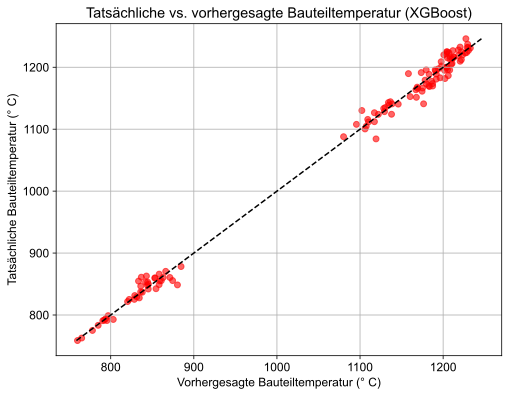

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(


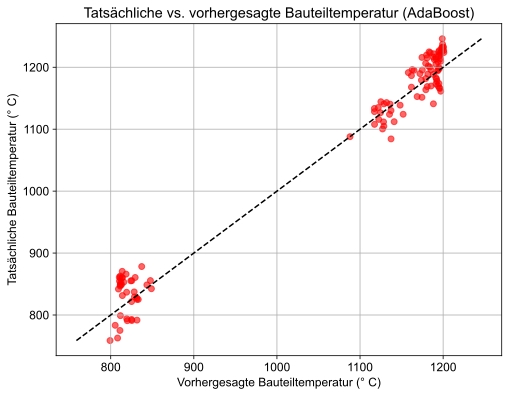

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


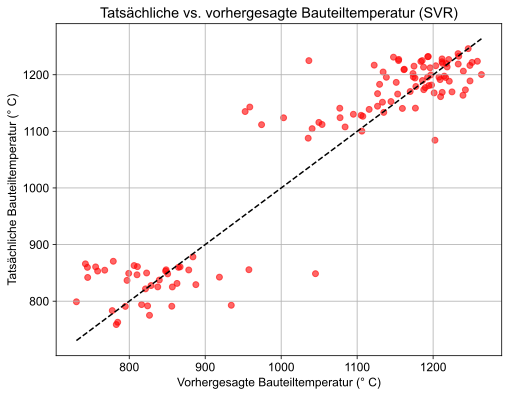

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


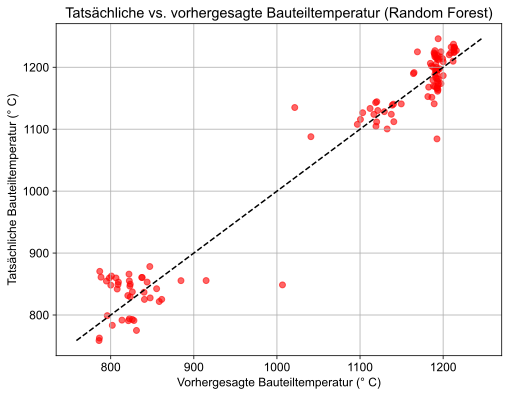

/opt/anaconda3/envs/conda310/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


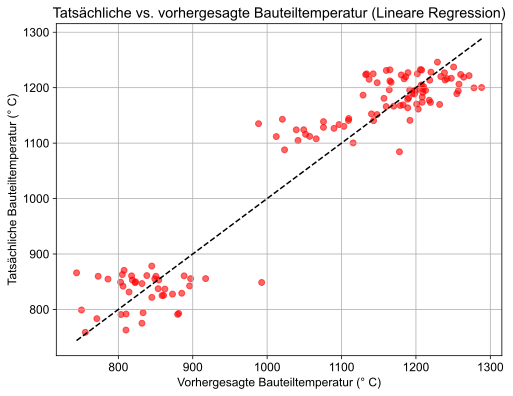

Fehler: Modell 'Lineare Regression' wurde nicht gefunden.


In [24]:
%config InlineBackend.figure_format = 'svg'
# Schritt 2: Vorhersagen für ein Modell generieren (z. B. XGBoost)
for model_name in best_pipelines:
    model = best_pipelines[model_name]
    y_pred = model.predict(X_test)

    # Schritt 3: Visualisierung
    plot_actual_vs_predicted(y_test, y_pred, model_name=model_name)
else:
    print(f"Fehler: Modell '{model_name}' wurde nicht gefunden.")

## Overfitting Test


Learning Curve Analyse für Bauteiltempartur:
Analysiere Modell: XGBoost...
Erstelle Validation Curve für XGBoost...
Validation Curve gespeichert unter: results/Bauteiltempartur//new_features/XGBoost/validation_curve_XGBoost_clf__n_estimators.svg


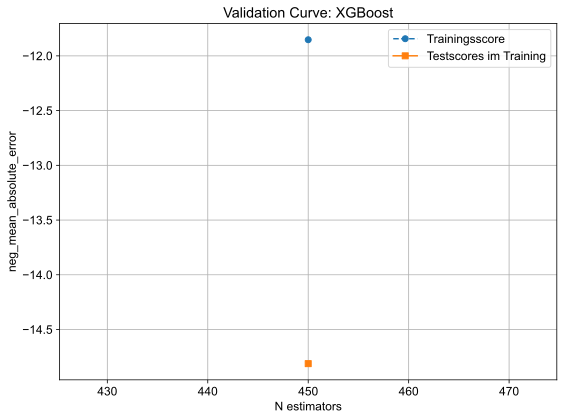

Erstelle Learning Curve für XGBoost...
Learning Curve gespeichert unter: results/Bauteiltempartur//new_features/XGBoost/learning_curve_XGBoost.svg


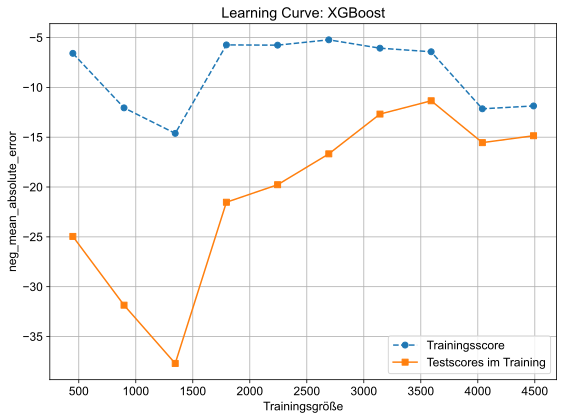

Analysiere Modell: AdaBoost...
Erstelle Validation Curve für AdaBoost...
Validation Curve gespeichert unter: results/Bauteiltempartur//new_features/AdaBoost/validation_curve_AdaBoost_clf__n_estimators.svg


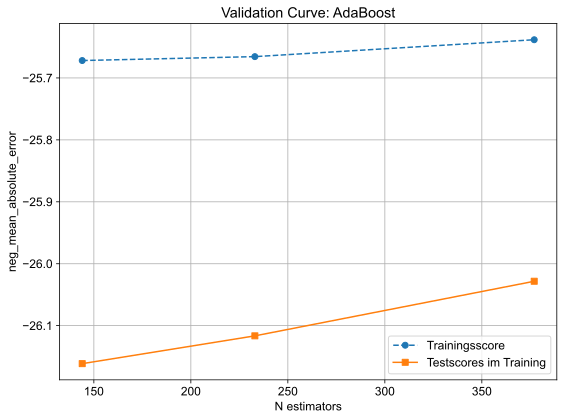

Erstelle Learning Curve für AdaBoost...
Learning Curve gespeichert unter: results/Bauteiltempartur//new_features/AdaBoost/learning_curve_AdaBoost.svg


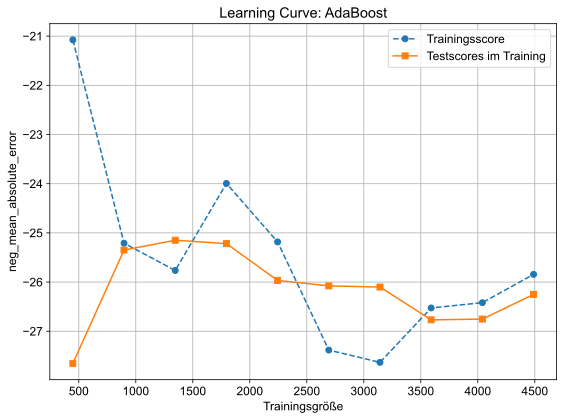

Analysiere Modell: SVR...
Erstelle Validation Curve für SVR...
Validation Curve gespeichert unter: results/Bauteiltempartur//new_features/SVR/validation_curve_SVR_clf__C.svg


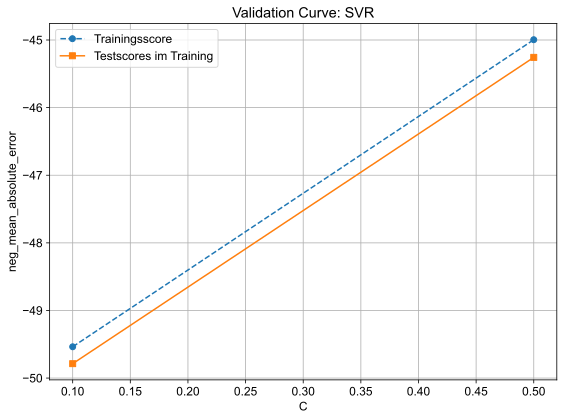

Erstelle Learning Curve für SVR...
Learning Curve gespeichert unter: results/Bauteiltempartur//new_features/SVR/learning_curve_SVR.svg


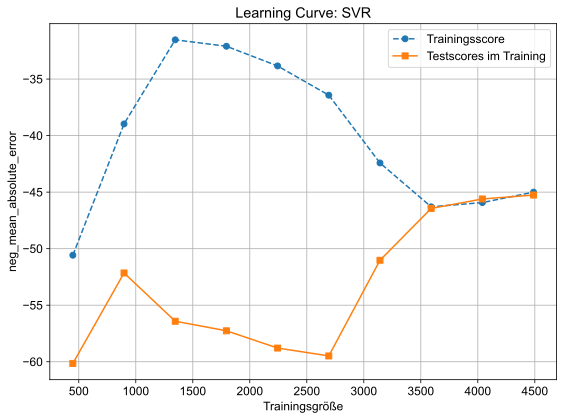

Analysiere Modell: Random Forest...
Erstelle Validation Curve für Random Forest...
Validation Curve gespeichert unter: results/Bauteiltempartur//new_features/Random Forest/validation_curve_Random Forest_clf__n_estimators.svg


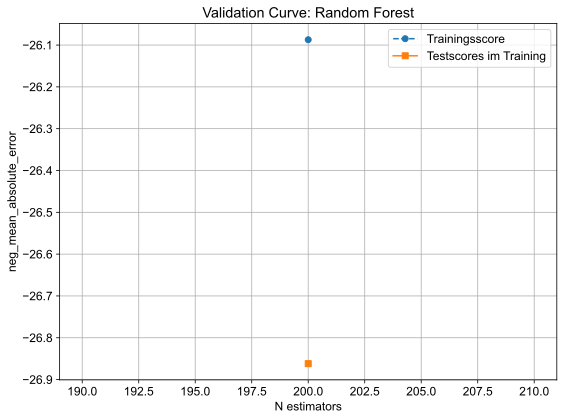

Erstelle Learning Curve für Random Forest...
Learning Curve gespeichert unter: results/Bauteiltempartur//new_features/Random Forest/learning_curve_Random Forest.svg


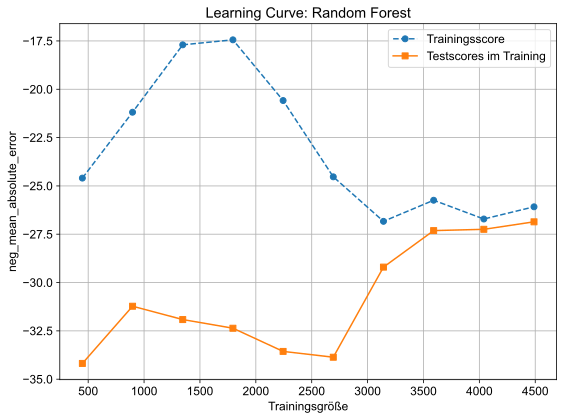

Analysiere Modell: Lineare Regression...
Keine Hyperparameter für Lineare Regression gefunden.


In [25]:
# Overfitting überprüfen 
# Analyse von Learning Curves für Bias-Variance-Tradeoff
print(f"\nLearning Curve Analyse für {target_name}:")

# Analyse der Modellleistung
analyze_model_performance(
    pipelines=pipelines, 
    param_grids=param_grids, 
    X=X_train, 
    y=y_train, 
    scoring=metric, 
    cv=kf,
    save_plots=save_plots,
    output_dir= target_dir,
    Verkippung=Verkippung
)


## SHAP-Analyse

In [26]:
# SHAP-Analyse
if shap_on:
    shap_analysis(
        best_pipelines=best_pipelines,
        X_train=X_train,
        target_name=target_name,
        dataset_name=dataset_name,
        output_dir=target_dir,
        plot_type=plot_type,  # Alternativ: "bar" oder "interaction" oder "violin"
        save_plots=save_plots,
        verkippung=Verkippung
    ) 

# Vergleich der Results 


In [27]:
results_dfs = {
    "Process Features": results_df_1,
    "Aggregated Features": results_df_2,
    "New Features": results_df_3
}

# Vergleich der Ergebnisse über die Datasets hinweg
compare_metric = "Test MSE"
comparison_table, best_combination = compare_results_regression(results_dfs, metric=compare_metric)

# Vergleichstabelle in HTML-Format konvertieren und anzeigen
print(f"Vergleich der {compare_metric}-Scores für die unterschiedlichen Datasets und Modelle:")
display(HTML(comparison_table.to_html()))

# Beste Kombination ausgeben
print(f"\nBeste Kombination:")
print(f"Dataset: {best_combination[0]}, Modell: {best_combination[1]}, Score: {best_combination[2]:.4f}")

save_scores_to_csv(
    results=comparison_table,
    output_dir=target_dir,
    file_name=f"compare_model_scores_{target_name}_{compare_metric}.csv",
    Verkippung=Verkippung
)

Vergleich der Test MSE-Scores für die unterschiedlichen Datasets und Modelle:


Dataset,Process Features,Aggregated Features,New Features
Model,,,
AdaBoost,1457.196909,851.852985,764.910068
XGBoost,4186.860505,2390.932703,131.231299
Random Forest,4845.576513,1527.735639,1186.439024
SVR,7775.623501,4319.397380,3636.783344
Lineare Regression,8514.115939,2793.572701,2573.987328



Beste Kombination:
Dataset: New Features, Modell: XGBoost, Score: 131.2313
Scores erfolgreich gespeichert unter: results/Bauteiltempartur//new_features/compare_model_scores_Bauteiltempartur_Test MSE.csv


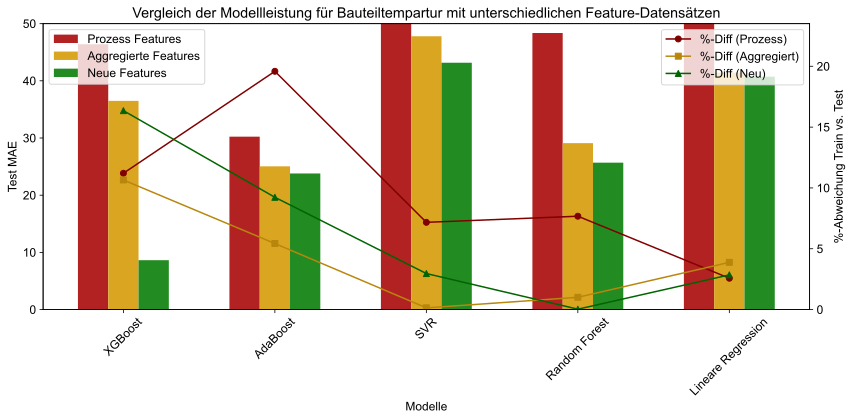

In [ ]:
output_path = f"../results/{target_name}/{balance_suffix}{tilt_suffix}{temp_suffix}/compare_model_scores_{target_name}_{compare_metric}{balance_suffix}{tilt_suffix}{temp_suffix}.svg"

# Diagramm erstellen
# RMSE macht mehr Sinn prozentual zu vergleichen als der MSE, da dieser in Original Einheiten ist
plot_scores_and_percent_diff(results_dfs, target_name=target_name, output_path=output_path, y_lim=(0, 50), metric="Test MAE")

# Visualisierungen


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(y_true, y_pred, model_name="Modell"):
    """
    Erstellt einen Scatter-Plot für tatsächliche vs. vorhergesagte Werte.
    
    Args:
        y_true (array-like): Tatsächliche Werte.
        y_pred (array-like): Vorhergesagte Werte.
        model_name (str): Name des Modells für den Titel.
    """
    plt.figure(figsize=(8, 6))
    
    # Streudiagramm
    plt.scatter(y_pred, y_true, color='red', alpha=0.6, label="Datenpunkte")
    
    # Diagonale Linie (perfekte Vorhersage)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Perfekte Vorhersage")
    
    # Achsenbeschriftung
    plt.xlabel("Vorhergesagte Probenhöhe (mm)")
    plt.ylabel("Tatsächliche Probenhöhe (mm)")
    plt.title(f"Tatsächliche vs. vorhergesagte Probenhöhe ({model_name})")
    plt.legend()
    plt.grid(True)
    
    plt.show()

## SMOTE für Prozess Features


Plot gespeichert unter: ./results/Bauteiltempartur/compare_SMOTE_process_features_Bauteiltempartur_Test MSE.svg


<Figure size 1000x600 with 0 Axes>

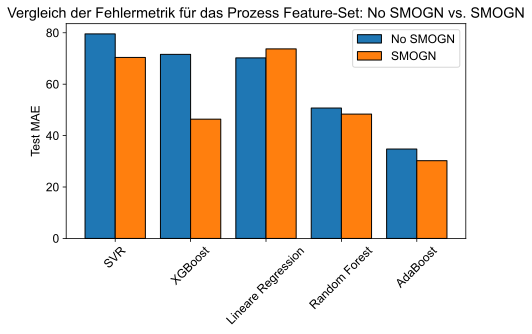

In [ ]:
smote_path = f"../results/{target_name}/{tilt_suffix}{temp_suffix}/process_features/model_scores_process_features.csv"
no_smote_path = f"../results/{target_name}/noSMOTE{tilt_suffix}{temp_suffix}/process_features/model_scores_process_featuresnoSMOTE.csv"
output_path = f"../results/{target_name}/compare_SMOTE_process_features_{target_name}_{compare_metric}.svg"
df_comp = compare_smote_effects(no_smote_path, smote_path, metric="Test MAE", title=f"Vergleich der Fehlermetrik für das Prozess Feature-Set: No SMOGN vs. SMOGN", save_path=output_path)
